# Multi-class classification on Stack Overflow questions
<https://www.tensorflow.org/tutorials/keras/text_classification#exercise_multi-class_classification_on_stack_overflow_questions>

In [1]:
%matplotlib inline
SEED = 42

In [2]:
from tensorflow.python import keras  #workaround for PyCharm

2023-06-18 16:55:52.668367: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-18 16:55:53.310510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# dataset url:
# https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz

import os

dataset_dir = os.path.join(os.getcwd(), 'dataset')
dataset_name = 'stack_overflow_16k'
dataset_path = os.path.join(dataset_dir, dataset_name)

assert os.path.exists(dataset_path)
print(dataset_path)

/mnt/c/Users/Jan/Desktop/machine-learning/tf/dataset/stack_overflow_16k


In [4]:
from keras import utils

batch_size = 64
validation_split = 0.2
label_mode = 'int'

train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')


def get_dataset(subset):
    return utils.text_dataset_from_directory(
        train_dir,
        label_mode=label_mode,
        batch_size=batch_size,
        shuffle=True,
        validation_split=validation_split,
        subset=subset,
        seed=SEED)


raw_train_ds = get_dataset('training')
raw_val_ds = get_dataset('validation')
raw_test_ds = utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    label_mode=label_mode)


Found 8000 files belonging to 4 classes.
Using 6400 files for training.


2023-06-18 16:56:06.939218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-18 16:56:06.974614: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-18 16:56:06.974670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-18 16:56:06.975983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-18 16:56:06.976053: I tensorflow/compile

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


In [5]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(label_batch[i].numpy(), text_batch.numpy()[i])


2023-06-18 16:56:33.254082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6400]
	 [[{{node Placeholder/_0}}]]
2023-06-18 16:56:33.254434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6400]
	 [[{{node Placeholder/_4}}]]


3 b'"unboundlocalerror: pygame music play and stop not working (on keydown) i\'m trying to play and stop a music in my main page...it\'s kind of weird..from my code,.if the user press ""m"", suppose, the music should be off..however, the music didn\'t off. it continue..unboundlocalerror: local variable \'music_playing\' referenced before assignment  ...can someone help me with my code?..pickupsound = pygame.mixer.music.load(\'test.mp3\').pygame.mixer.music.play(-1).music_playing = true..def mainmenu():.    main = pygame.image.load(\'menu.jpg\').    screen.blit(main,(0,0)).    while true:.        pygame.display.update().        for event in pygame.event.get():.            if event.type == pygame.quit:.                pygame.quit().                quit().            if event.type == keydown:.                if event.key == ord(\'m\'):.                    if music_playing:.                        pygame.mixer.music.stop().                    else:.                        pygame.mixer.musi

In [25]:
import string
import re
import tensorflow as tf

from keras import layers

vocab_size = 10000


def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<.*>', ' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')


encoder = layers.TextVectorization(
    max_tokens=vocab_size,
    standardize=custom_standardization,
    output_mode='int',
    # output_sequence_length=1000
)

train_text = raw_train_ds.map(lambda text, labels: text)
encoder.adapt(train_text)

2023-06-18 17:16:27.582543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6400]
	 [[{{node Placeholder/_0}}]]
2023-06-18 17:16:27.582845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6400]
	 [[{{node Placeholder/_0}}]]


In [26]:
import numpy as np

np.array(encoder.get_vocabulary())[:10]

array(['', '[UNK]', 'the', 'i', 'to', 'a', 'is', 'in', 'and', 'of'],
      dtype='<U83')

In [27]:
# process and optimize dataset
autotune = tf.data.AUTOTUNE
buffer_size = 10000


def process_text(text, label):
    text = tf.expand_dims(text, -1)
    return encoder(text), label


train_ds = raw_train_ds.map(process_text).shuffle(buffer_size).prefetch(autotune)
val_ds = raw_val_ds.map(process_text).shuffle(buffer_size).prefetch(autotune)
test_ds = raw_test_ds.map(process_text).prefetch(autotune)

In [28]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [29]:
class_count = len(raw_train_ds.class_names)

In [74]:
from keras import models


def create_model():
    # Input for variable-length sequences of integers
    # inputs = keras.Input(shape=(None,), dtype="int32")
    inputs = layers.Input(shape=(1,), batch_size=batch_size, dtype="int32")

    # Embed each integer in a 64-dimensional vector
    x = layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True)(inputs)

    # Add bidirectional LSTM
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    # print(x)
    # x = layers.LSTM(64)(x)

    # Add dense layers
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(class_count, activation="sigmoid")(x)

    model = models.Model(inputs, outputs)
    return model


In [75]:
def print_base_model():
    m = create_model()
    display(m.summary())
    display([layer.supports_masking for layer in m.layers])


print_base_model()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(64, 1)]                 0         
                                                                 
 embedding_2 (Embedding)     (64, 1, 64)               640000    
                                                                 
 bidirectional_2 (Bidirectio  (64, 1, 128)             66048     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (64, 128)                98816     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (64, 64)                  8256      
                                                                 
 dense_5 (Dense)             (64, 4)                   260 

None

[True, True, True, True, True, True]

In [76]:
import keras_tuner as kt
from keras import callbacks
from keras import losses
from keras import optimizers


def model_builder(hp):
    model = create_model()

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=optimizers.Adam(hp_learning_rate),
                  metrics=['accuracy'])

    return model


tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='dataset',
                     project_name='so-questions-hyperparams')
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=5)

INFO:tensorflow:Reloading Tuner from dataset/so-questions-hyperparams/tuner0.json


In [77]:
tuner.search(train_ds, epochs=5, validation_data=val_ds, callbacks=[stop_early])
# history = model.fit(train_ds, epochs=3,
#                     validation_data=val_ds)

Trial 3 Complete [00h 00m 54s]
val_accuracy: 0.7418749928474426

Best val_accuracy So Far: 0.7418749928474426
Total elapsed time: 00h 00m 54s
INFO:tensorflow:Oracle triggered exit


In [79]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.get('learning_rate')

0.001

In [80]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds,
                    callbacks=[stop_early],
                    )

Epoch 1/30


2023-06-18 18:01:08.560162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-06-18 18:01:09.695962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-06-18 18:01:13.054591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ign

100/100 [==============================] - 33s 144ms/step - loss: 1.1189 - accuracy: 0.4702 - val_loss: 0.7541 - val_accuracy: 0.6656
Epoch 2/30
100/100 [==============================] - 18s 114ms/step - loss: 0.6329 - accuracy: 0.7191 - val_loss: 0.6676 - val_accuracy: 0.7269
Epoch 3/30
100/100 [==============================] - 19s 111ms/step - loss: 0.4505 - accuracy: 0.8292 - val_loss: 0.6414 - val_accuracy: 0.7600
Epoch 4/30
100/100 [==============================] - 18s 111ms/step - loss: 0.2802 - accuracy: 0.9016 - val_loss: 0.6768 - val_accuracy: 0.7644
Epoch 5/30
100/100 [==============================] - 18s 108ms/step - loss: 0.2119 - accuracy: 0.9237 - val_loss: 0.7489 - val_accuracy: 0.7487
Epoch 6/30
100/100 [==============================] - 18s 108ms/step - loss: 0.1615 - accuracy: 0.9463 - val_loss: 0.7623 - val_accuracy: 0.7625
Epoch 7/30
100/100 [==============================] - 19s 114ms/step - loss: 0.1347 - accuracy: 0.9528 - val_loss: 0.8766 - val_accuracy: 0.7

In [82]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

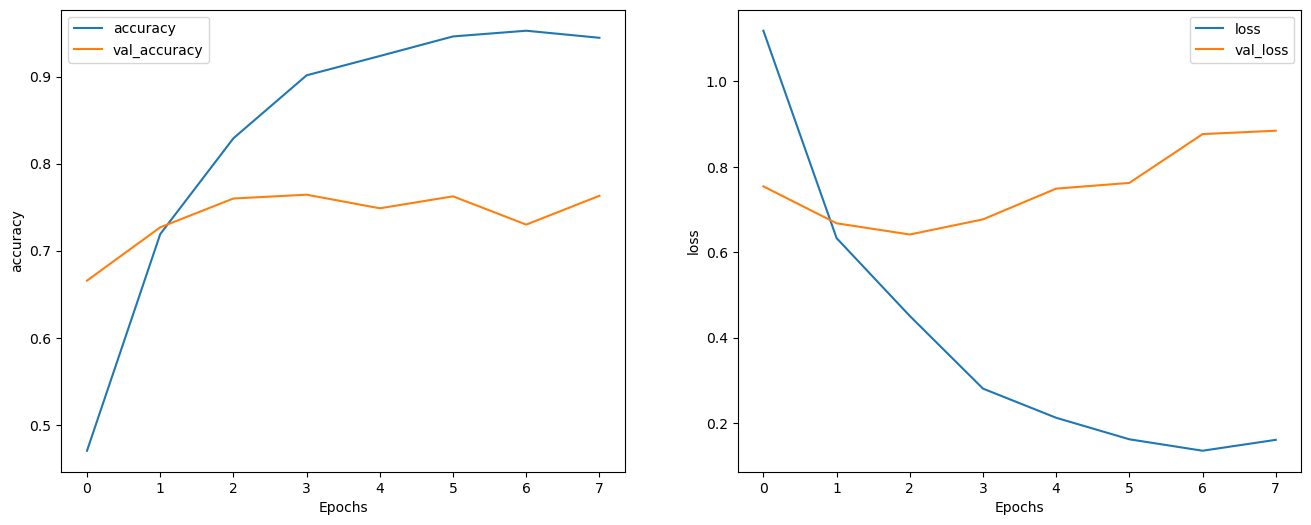

In [83]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [81]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

125/125 [==============================] - 11s 75ms/step - loss: 1.0062 - accuracy: 0.7450
Test Loss: 1.006170392036438
Test Accuracy: 0.7450000047683716
